# Sentiment analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_train = pd.read_csv('data/train.csv')
df_valid = pd.read_csv('data/valid.csv')
df_test = pd.read_csv('data/test.csv')

In [3]:
print(df_train.head())

                                                text  label
0  I grew up (b. 1965) watching and loving the Th...      0
1  When I put this movie in my DVD player, and sa...      0
2  Why do people who do not know what a particula...      0
3  Even though I have great interest in Biblical ...      0
4  Im a die hard Dads Army fan and nothing will e...      1


In [4]:
print(df_valid.head())

                                                text  label
0  It's been about 14 years since Sharon Stone aw...      0
1  someone needed to make a car payment... this i...      0
2  The Guidelines state that a comment must conta...      0
3  This movie is a muddled mish-mash of clichés f...      0
4  Before Stan Laurel became the smaller half of ...      0


In [5]:
print(df_test.head())

                                                text  label
0  I always wrote this series off as being a comp...      0
1  1st watched 12/7/2002 - 3 out of 10(Dir-Steve ...      0
2  This movie was so poorly written and directed ...      0
3  The most interesting thing about Miryang (Secr...      1
4  when i first read about "berlin am meer" i did...      0


# Distribution of length

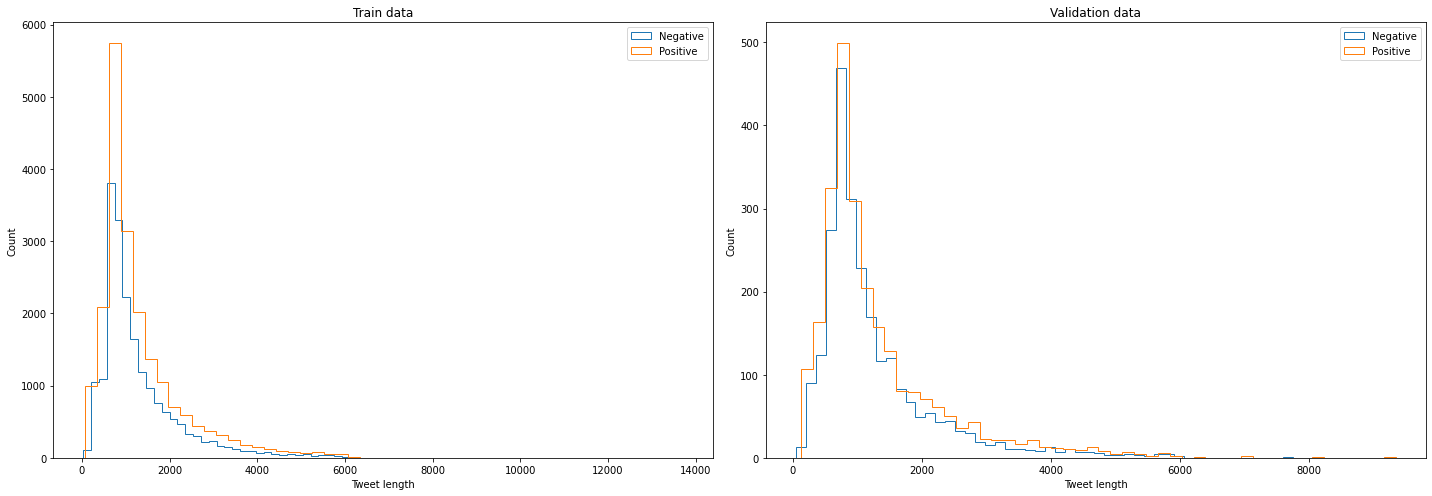

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7))

ax[0].hist(df_train[df_train['label'] == 0]['text'].str.len(), bins=50, label='Negative', histtype='step')
ax[0].hist(df_train[df_train['label'] == 1]['text'].str.len(), bins=50, label='Positive', histtype='step')

ax[0].set_xlabel('Tweet length')
ax[0].set_ylabel('Count')
ax[0].set_title('Train data')
ax[0].legend(loc='best')

ax[1].hist(df_valid[df_valid['label'] == 0]['text'].str.len(), bins=50, label='Negative', histtype='step')
ax[1].hist(df_valid[df_valid['label'] == 1]['text'].str.len(), bins=50, label='Positive', histtype='step')

ax[1].set_xlabel('Tweet length')
ax[1].set_ylabel('Count')
ax[1].set_title('Validation data')
ax[1].legend(loc='best')

plt.tight_layout()
plt.show()

# Class balance

In [7]:
def get_length(X, val):
    view = X[X['label'] == val]
    total = len(X)
    return len(view) / total

print(get_length(df_train, 0))
print(get_length(df_train, 1))

print(get_length(df_valid, 0))
print(get_length(df_valid, 1))

print(get_length(df_test, 0))
print(get_length(df_test, 1))

0.500475
0.499525
0.4972
0.5028
0.499
0.501


# Preprocessing
* Change text to lower case
* Remove any urls
* Remove punctuation
* Remove stopwords

In [8]:
# lower case
df_train['text'] = df_train['text'].str.lower()
df_valid['text'] = df_valid['text'].str.lower()
df_test['text'] = df_test['text'].str.lower()

In [9]:
# remove URLS
import re

def remove_urls(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    
    return url.sub(r'', text)

df_train['text'] = df_train['text'].apply(remove_urls)
df_valid['text'] = df_valid['text'].apply(remove_urls)
df_test['text'] = df_test['text'].apply(remove_urls)

In [10]:
# removing punctuation
def remove_punctuation(text):
    text = text.replace('.', '')
    text = text.replace(',', '')
    text = text.replace('!', '')
    text = text.replace('?', '')
    text = text.replace('"', '')
    text = text.replace("'", '')
    text = text.replace(':', '')
    text = text.replace(';', '')
    # remove @? Might want to strip twitter usernames later
    return text

df_train['text'] = df_train['text'].apply(remove_punctuation)
df_valid['text'] = df_valid['text'].apply(remove_punctuation)
df_test['text'] = df_test['text'].apply(remove_punctuation)

In [11]:
# removing stop words
import nltk
from nltk.corpus import stopwords

def remove_stopwords(text):
    sw = stopwords.words('english')
    words = text.split(' ')
    filtered = [w for w in words if w not in sw]
    return ' '.join([str(v) for v in filtered])

df_train['text'] = df_train['text'].apply(remove_stopwords)
df_valid['text'] = df_valid['text'].apply(remove_stopwords)
df_test['text'] = df_test['text'].apply(remove_stopwords)

# DQ issues - missing data

In [12]:
print(df_train['text'].isna().sum())
print(df_valid['text'].isna().sum())
print(df_test['text'].isna().sum())

0
0
0


# Setup model

In [13]:
X_train, y_train = df_train['text'].to_numpy(), df_train['label'].to_numpy()
X_valid, y_valid = df_valid['text'].to_numpy(), df_valid['label'].to_numpy()
X_test, y_test = df_test['text'].to_numpy(), df_test['label'].to_numpy()

In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

n_words = 5000
max_length = 100
tokenizer = Tokenizer(oov_token='<OOV>', num_words=n_words)
tokenizer.fit_on_texts(np.concatenate([X_train, X_valid]))
word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(X_train)
training_padded = pad_sequences(training_sequences, padding='post', maxlen=max_length)

valid_sequences = tokenizer.texts_to_sequences(X_valid)
valid_padded = pad_sequences(valid_sequences, padding='post', maxlen=max_length)

test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, padding='post', maxlen=max_length)

2022-03-20 17:32:18.610459: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-20 17:32:18.610478: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, GlobalAveragePooling1D, Dropout, Bidirectional
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import Adam, SGD

reg = None
#reg = 'l1'

# model
model = Sequential()
model.add(Embedding(n_words, 30))
#model.add(LSTM(50, activation='relu', return_sequences=False))
model.add(Bidirectional(LSTM(30, activation='relu', return_sequences=False)))
#model.add(Dropout(0.4))
model.add(Dense(10, activation='relu', kernel_regularizer=reg))
model.add(Dense(1, activation='sigmoid'))

# loss/optimizers
# learning_rate = 0.0001 # too slow
learning_rate = 0.001
#learning_rate = 0.01
optimizer = SGD(learning_rate=learning_rate, momentum=0.99)

# metrics
#metrics = ['accuracy', Precision(), Recall()]
metrics = ['accuracy']

model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=metrics)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 30)          150000    
_________________________________________________________________
bidirectional (Bidirectional (None, 60)                14640     
_________________________________________________________________
dense (Dense)                (None, 10)                610       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 165,261
Trainable params: 165,261
Non-trainable params: 0
_________________________________________________________________


2022-03-20 17:32:26.943903: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-20 17:32:26.943924: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-20 17:32:26.943939: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sdysch-Lenovo-IdeaPad-S540-15IML): /proc/driver/nvidia/version does not exist
2022-03-20 17:32:26.944120: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

es = EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=20, verbose=1, restore_best_weights=True, mode='auto')
lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=10, verbose=1, mode="auto", min_delta=0.0001, cooldown=0, min_lr=0.000000001)
#callbacks = [lr]
#callbacks = [es]
callbacks = []
    
epochs = 20
#epochs = 30

#batch_size = 64
batch_size = 32

history = model.fit(training_padded,
          y_train,
          batch_size=batch_size,
          epochs=epochs,
          callbacks=callbacks,
          validation_data=(valid_padded, y_valid),
          shuffle=True)

2022-03-20 17:32:27.142518: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-03-20 17:32:27.165551: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2099940000 Hz


1250/1250 [==============================] - 35s 27ms/step - loss: 0.6934 - accuracy: 0.5012 - val_loss: 0.6934 - val_accuracy: 0.5028
Epoch 2/20
1250/1250 [==============================] - 37s 29ms/step - loss: 0.6928 - accuracy: 0.5109 - val_loss: 0.6929 - val_accuracy: 0.4964
Epoch 3/20
1250/1250 [==============================] - 38s 30ms/step - loss: 0.6908 - accuracy: 0.5266 - val_loss: 0.6879 - val_accuracy: 0.5376
Epoch 4/20
1250/1250 [==============================] - 37s 29ms/step - loss: 0.6823 - accuracy: 0.5598 - val_loss: 0.6803 - val_accuracy: 0.5584
Epoch 5/20
1250/1250 [==============================] - 37s 29ms/step - loss: 0.6330 - accuracy: 0.6487 - val_loss: 0.6090 - val_accuracy: 0.6772
Epoch 6/20
1250/1250 [==============================] - 37s 30ms/step - loss: 0.5196 - accuracy: 0.7495 - val_loss: 0.4266 - val_accuracy: 0.8228
Epoch 7/20
1250/1250 [==============================] - 37s 29ms/step - loss: 0.3811 - accuracy: 0.8355 - val_loss: 0.3390 - val_accura

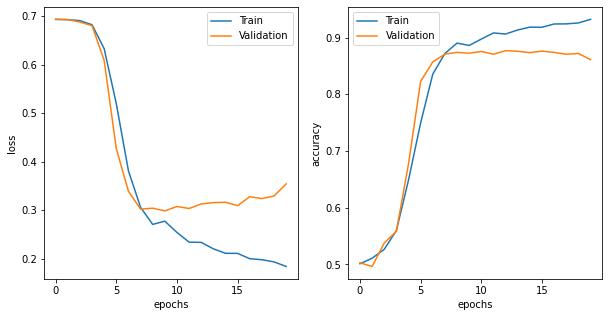

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(history.history['loss'], label='Train')
ax[0].plot(history.history['val_loss'], label='Validation')
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('loss')
ax[0].legend(loc='best')
#ax[0].set_yscale('log')

ax[1].plot(history.history['accuracy'], label='Train')
ax[1].plot(history.history['val_accuracy'], label='Validation')
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('accuracy')
ax[1].legend(loc='best')


plt.show()

Accuracy: 0.8598
Precision: 0.8147243545010467
Recall: 0.9321357285429142


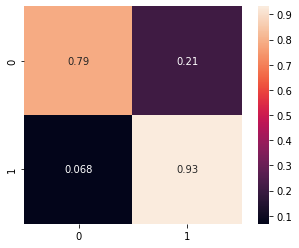

In [18]:
# confusion matrix
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score

y_pred = model.predict(test_padded)
y_pred = y_pred > 0.5

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred)}')
print(f'Recall: {recall_score(y_test, y_pred)}')

cm = confusion_matrix(y_test, y_pred, normalize='true')
# print(cm)
sns.heatmap(cm, annot=True, square=True)